# 测试

In [1]:
import torch
from torch import nn, fx, optim
from torch.nn import functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from torch.ao.quantization.observer import HistogramObserver
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.data.simple_vision import load_data_cifar10
from torch_book.tools import train, try_all_gpus #try_gpu
from torch_book.tools import evaluate_accuracy_gpu
from fixed_sigmoid import linear_sigmoid


torch.cuda.empty_cache() # 清空 GPU 缓存

batch_size = 32
train_iter, test_iter = load_data_cifar10(batch_size=batch_size)
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                        model.conv1.out_channels, 
                        3, 1, 1)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)

# 替换 ReLU 为 torch.sigmoid
mod = fx.symbolic_trace(model)
# 遍历 Graph 中全部节点
for node in mod.graph.nodes:
    # 如果匹配目标
    if node.op == "call_module":
        if "relu" in node.target:
            # 设置插入点，添加新节点，用新节点替换所有 `node` 的用法
            with mod.graph.inserting_after(node):
                new_node = mod.graph.call_function(torch.sigmoid, node.args, node.kwargs)
                node.replace_all_uses_with(new_node)
            # 移除 graph 中旧的节点
            mod.graph.erase_node(node)
mod.graph.lint()
# 不用忘记 recompile!
new_code = mod.recompile()

# 加载模型参数
state_dict = torch.load("models/resnet18_cifar10_sigmoid.h5")
mod.load_state_dict(state_dict)

Files already downloaded and verified
Files already downloaded and verified


<All keys matched successfully>

In [2]:
# 遍历 Graph 中全部节点
for node in mod.graph.nodes:
    # 如果匹配目标
    if node.op == "call_function":
        if node.target == torch.sigmoid:
            node.target = linear_sigmoid
        # if "sigmoid" == node.name:
        #      # 设置插入点，添加新节点，用新节点替换所有 `node` 的用法
        #     with mod.graph.inserting_after(node):
        #         new_node = mod.graph.call_function(linear_sigmoid, node.args, node.kwargs)
        #         node.replace_all_uses_with(new_node)
        #     # 移除 graph 中旧的节点
        #     mod.graph.erase_node(node)
        #     break
mod.graph.lint()
# 不用忘记 recompile!
new_code = mod.recompile()

In [3]:
print(mod.code)




def forward(self, x : torch.Tensor) -> torch.Tensor:
    conv1 = self.conv1(x);  x = None
    bn1 = self.bn1(conv1);  conv1 = None
    sigmoid = fixed_sigmoid_linear_sigmoid(bn1);  bn1 = None
    maxpool = self.maxpool(sigmoid);  sigmoid = None
    layer1_0_conv1 = getattr(self.layer1, "0").conv1(maxpool)
    layer1_0_bn1 = getattr(self.layer1, "0").bn1(layer1_0_conv1);  layer1_0_conv1 = None
    sigmoid_1 = fixed_sigmoid_linear_sigmoid(layer1_0_bn1);  layer1_0_bn1 = None
    layer1_0_conv2 = getattr(self.layer1, "0").conv2(sigmoid_1);  sigmoid_1 = None
    layer1_0_bn2 = getattr(self.layer1, "0").bn2(layer1_0_conv2);  layer1_0_conv2 = None
    add = layer1_0_bn2 + maxpool;  layer1_0_bn2 = maxpool = None
    sigmoid_2 = fixed_sigmoid_linear_sigmoid(add);  add = None
    layer1_1_conv1 = getattr(self.layer1, "1").conv1(sigmoid_2)
    layer1_1_bn1 = getattr(self.layer1, "1").bn1(layer1_1_conv1);  layer1_1_conv1 = None
    sigmoid_3 = fixed_sigmoid_linear_sigmoid(layer1_1_bn1);  layer1

获取线性化之后的模型的测试精度：

In [5]:
valid_acc = evaluate_accuracy_gpu(mod, test_iter)
valid_acc

0.221

微调：

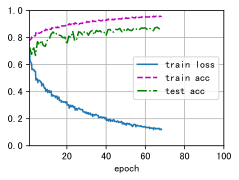

In [7]:
lr, num_epochs = 0.00142857, 100
weight_decay = 0.0007142857142857143
momentum = 0.857142
lr_period = 4
lr_decay = 0.857142
devices = try_all_gpus()
optimizer = optim.SGD(mod.parameters(), 
                      lr=lr, 
                      momentum=momentum, 
                      weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=lr_period, 
                                      gamma=lr_decay)
train(mod, train_iter, test_iter,
      num_epochs, devices,
      optimizer, scheduler)